In [1]:
#!ls ~/trained_models/
import pandas as pd
pd.set_option('display.max_colwidth', 20)   # JSON columns make things look weird in notebook without this

In [2]:
from itertools import chain
from pathlib import Path
from datatype_recovery.models.dataset import load_dataset_from_path, max_typesequence_len_in_dataset
from datatype_recovery.models.dataset.encoding import *

import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from tqdm import tqdm

from datatype_recovery.models.metrics import acc_heuristic_numcorrect

def eval_model_on_dataset(model_path:Path, device:str, dataset_path:Path) -> float:
    '''
    Evaluates the model on the given dataset and returns the accuracy of the corrected
    model output against the dataset labels
    '''
    dataset = load_dataset_from_path(dataset_path)
    include_comp = not dataset.drop_component
    max_true_seq_len = max_typesequence_len_in_dataset(dataset_path)
    return eval_model_on_subset(model_path, device, dataset, max_true_seq_len, include_comp)

def eval_model_on_subset(model_path:Path, device:str, dataset, max_true_seq_len:int, include_comp:bool) -> float:
    '''
    Evaluates the model on the given subset and returns the accuracy of the corrected
    model output against the dataset labels
    '''
    model = torch.load(model_path)
    print(model)

    # take the max of model seq length and max seq length of dataset so we
    # calculate accuracy correctly (without truncating something)
    max_len = max(model.max_seq_len, max_true_seq_len)

    # prepare the data loaders
    batch_size = 64
    dataset.transform = T.Compose([ToBatchTensors(), ToFixedLengthTypeSeq(max_len)])

    # split the dataset into the part divisible by batch size and the leftovers
    # we can chain these together for performance - our metrics simply iterate
    # through all elements in the batch
    batched_total = len(dataset)-(len(dataset)%batch_size)
    batch_loader = DataLoader(dataset[:batched_total], batch_size=batch_size)
    leftovers_loader = DataLoader(dataset[batched_total:], batch_size=1)

    print(f'Running eval...')

    model.to(device)
    model.eval()
    num_correct = 0

    for data in tqdm(chain(batch_loader, leftovers_loader), total=len(batch_loader)+len(leftovers_loader)):
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        num_correct += acc_heuristic_numcorrect(data.y, out, include_comp)

    accuracy = num_correct/len(dataset)
    print(f'Accuracy = {accuracy*100:,.2f}%')

    return accuracy

In [3]:
# TODO: eval on an interesting subset of the data
# from torch.utils.data import Subset
# Subset()

In [4]:
# dataset_path = Path.home()/'datasets/test_ds'
# dataset_path = Path.home()/'datasets/coreutils_5hops'
dataset_path = Path.home()/'datasets/trainset_astera_full_5hops_nocomp'
# model_path = Path.home()/'trained_models/RERUN_structural_3out_4hops_nocomp.pt'
model_path = Path.home()/'trained_models/dragon_4out_4hops_nocomp.pt'

# eval_model_on_dataset(model_path, 'cuda:3', dataset_path)

In [5]:
dataset = load_dataset_from_path(dataset_path)

In [6]:
df = dataset.read_vars_csv()
df

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,LocRegName_Debug,LocOffset_Debug,TypeCategory_Debug,TypeSeq_Debug,HasDWARF,TypeJson_Debug,BinaryId,Vartype,IsReturnType_Debug,IsReturnType_Strip
0,1323657,"16,28,52,76,101,...",local_c,int32,stack,NaN,-12.0,BUILTIN,int32,i,...,NaN,-12.0,BUILTIN,int32,True,"{""kind"": ""Builti...",1000,l,False,False
1,1323772,"16,28,52,76,101,...",local_c,int32,stack,NaN,-12.0,BUILTIN,int32,i,...,NaN,-12.0,BUILTIN,int32,True,"{""kind"": ""Builti...",1000,l,False,False
2,1323887,"17,29,53,79,79,87",local_c,int32,stack,NaN,-12.0,BUILTIN,int32,i,...,NaN,-12.0,BUILTIN,int32,True,"{""kind"": ""Builti...",1000,l,False,False
3,1323980,"21,96,96,104",local_c,int32,stack,NaN,-12.0,BUILTIN,int32,NaN,...,NaN,NaN,COMP,COMP,False,NaN,1000,l,False,False
4,1324093,"26,31",__x,float,register,xmm0_da,4608.0,BUILTIN,float,NaN,...,NaN,NaN,COMP,COMP,False,NaN,1000,l,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45693,1072065,-1,NaN,void,NaN,NaN,NaN,BUILTIN,void,NaN,...,NaN,NaN,BUILTIN,void,True,"{""kind"": ""Builti...",1008,p,True,True
45694,1072199,-1,NaN,uint64,NaN,NaN,NaN,BUILTIN,uint64,NaN,...,NaN,NaN,BUILTIN,uchar,True,"{""kind"": ""Builti...",1008,p,True,True
45695,1072670,-1,NaN,int32,NaN,NaN,NaN,BUILTIN,int32,NaN,...,NaN,NaN,BUILTIN,uchar,True,"{""kind"": ""Builti...",1008,p,True,True
45696,1072725,-1,NaN,void,NaN,NaN,NaN,BUILTIN,void,NaN,...,NaN,NaN,BUILTIN,void,True,"{""kind"": ""Builti...",1008,p,True,True


In [7]:
# TODO: predict data type with model for each variable in dataset
# --> save results in a new DF using varid
# --> join (merge) predictions into var_df so we can analyze the results however we wish

# NOTE: we can join right away, but then don't forget to filter out variables we
# discarded (COMP and return types are dropped) when we compute METRICS

In [11]:
from datatype_recovery.models.dataset.encoding import TypeSequence

def make_predictions_on_dataset(model_path:Path, device:str, dataset, max_true_seq_len:int) -> pd.DataFrame:
    '''
    Evaluates the model on the given dataset and returns a DataFrame containing the varid columns
    of each variable in the dataset along with its predicted type sequence (raw and corrected)
    '''
    model = torch.load(model_path)
    print(model)

    # take the max of model seq length and max seq length of dataset so we
    # calculate accuracy correctly (without truncating something)
    max_len = max(model.max_seq_len, max_true_seq_len)

    # prepare the data loaders
    batch_size = 512
    dataset.transform = T.Compose([ToBatchTensors(), ToFixedLengthTypeSeq(max_len, dataset.include_component)])

    # split the dataset into the part divisible by batch size and the leftovers
    # we can chain these together for performance - our metrics simply iterate
    # through all elements in the batch
    batched_total = len(dataset)-(len(dataset)%batch_size)
    batch_loader = DataLoader(dataset[:batched_total], batch_size=batch_size)
    leftovers_loader = DataLoader(dataset[batched_total:], batch_size=1)

    print(f'Running eval...')

    model.to(device)
    model.eval()

    model_outputs = []

    tseq = TypeSequence(dataset.include_component)

    for data in tqdm(chain(batch_loader, leftovers_loader), total=len(batch_loader)+len(leftovers_loader)):
        data.to(device)
        edge_attr = data.edge_attr if model.uses_edge_features else None
        out = model(data.x, data.edge_index, data.batch, edge_attr=edge_attr)

        for i, pred in enumerate(out):
            raw = tseq.decode(pred, drop_empty_elems=True)
            corrected = tseq.decode(pred, force_valid_seq=True)

            binid, funcstart, sig, vartype = data.varid[i]

            model_outputs.append((
                binid, funcstart, sig, vartype,
                ','.join(raw),
                ','.join(corrected),
            ))

    return pd.DataFrame.from_records(model_outputs, columns=['BinaryId','FunctionStart','Signature','Vartype','RawPred','Pred'])

In [13]:
max_true_len = df.TypeSeq_Debug.apply(lambda ts: len(ts.split(','))).max()
model_pred = make_predictions_on_dataset(model_path, 'cuda:1', dataset, max_true_len)
model_pred

DragonModel(
  (gat_layers): ModuleList(
    (0): GATConv(130, 128, heads=1)
    (1-3): 3 x GATConv(128, 128, heads=1)
  )
  (pred_head): Linear(128, 88, bias=True)
)
Running eval...


  0%|          | 0/145 [06:07<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (13869x127 and 130x128)

In [10]:
mdf = df.merge(model_pred, how='right', on=['BinaryId','FunctionStart','Signature','Vartype'])
mdf

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,TypeCategory_Debug,TypeSeq_Debug,HasDWARF,TypeJson_Debug,BinaryId,Vartype,IsReturnType_Debug,IsReturnType_Strip,RawPred,Pred
0,1056048,17,auStack_8,uchar[8],stack,NaN,-8.0,ARR,"ARR,uchar",auStack_8,...,ARR,"ARR,uchar",False,"{""kind"": ""ArrayT...",1000,l,False,False,"ARR,uchar","ARR,uchar"
1,1056281,"37,78,82,107,111",local_a8,rusage,stack,NaN,-168.0,STRUCT,STRUCT,usage,...,STRUCT,STRUCT,True,"{""kind"": ""Struct...",1000,l,False,False,"ARR,uchar","ARR,uchar"
2,1056281,"78,82,107,111,130",param_1,timeval*,register,rdi,56.0,PTR,"PTR,STRUCT",ts,...,PTR,"PTR,STRUCT",True,"{""kind"": ""Pointe...",1000,p,False,False,"STRUCT,short",STRUCT
3,1056439,"37,94,114",local_b8,timeval,stack,NaN,-184.0,STRUCT,STRUCT,real_end,...,STRUCT,STRUCT,True,"{""kind"": ""Struct...",1000,l,False,False,STRUCT,STRUCT
4,1056439,"57,160,180,226,246",local_a8,rusage,stack,NaN,-168.0,STRUCT,STRUCT,usage,...,STRUCT,STRUCT,True,"{""kind"": ""Struct...",1000,l,False,False,"ARR,uchar","ARR,uchar"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49851,1092462,20,param_1,uint32,register,edi,56.0,BUILTIN,uint32,category,...,BUILTIN,int32,True,"{""kind"": ""Builti...",1116,p,False,False,"ARR,float","ARR,float"
49852,1092496,"55,73,77,77,81",lVar1,int64,register,rbx,24.0,BUILTIN,int64,lVar1,...,BUILTIN,int64,False,"{""kind"": ""Builti...",1116,l,False,False,int64,int64
49853,1092624,13,param_1,uint64,register,rdi,56.0,BUILTIN,uint64,__func,...,PTR,"PTR,FUNC",False,"{""kind"": ""Pointe...",1116,p,False,False,int32,int32
49854,1094304,4,param_1,uint32,register,edi,56.0,BUILTIN,uint32,param_1,...,BUILTIN,uint32,False,"{""kind"": ""Builti...",1116,p,False,False,"ARR,float","ARR,float"


In [11]:
acc_corrected = len(mdf[mdf.TypeSeq_Debug==mdf.Pred])/len(mdf)*100
acc_corrected

# TODO: confusion matrix, F1, precision, recall from this mdf too

30.48780487804878

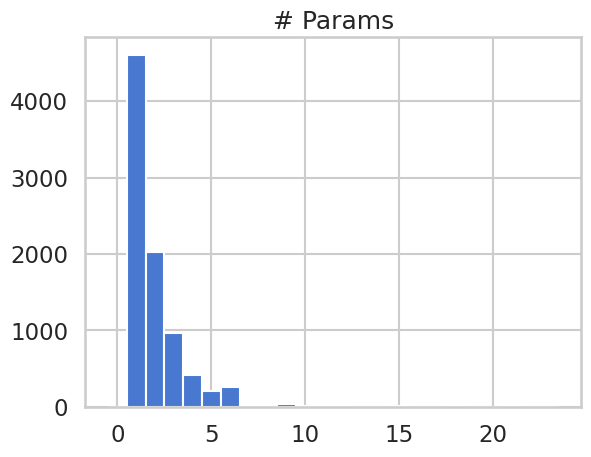

In [32]:
ax = df[(df.Vartype=='p')&(~df.IsReturnType_Debug)].groupby('FunctionStart').count()[['BinaryId']].rename({'BinaryId': '# Params'},axis=1).hist(
    # figsize=(18,5),
    bins=[x-0.5 for x in range(25)],
)
# ax[0][0].set_ylim([0, 500])

In [13]:
dataset_path

PosixPath('/home/cls0027/datasets/coreutils_5hops')

In [14]:
# TODO: eval_model(dataset, model, filter_dataset=lambda df: df[df.HasDWARF])
# --> need to calculate the pred_df ONLY ONCE but allow multiple metrics/evals to occur

from typing import Callable

class EvalSubset:
    '''
    Represents a subset of the overall dataset that will be evaluated
    '''
    def __init__(self, name:str, filter_dataset:Callable[[pd.DataFrame], pd.DataFrame]) -> None:
        self.name = name
        self.filter_dataset = filter_dataset


In [15]:
acc_raw = len(mdf[mdf.TypeSeq_Debug==mdf.RawPred])/len(mdf)*100
acc_raw

29.83191591784339

In [16]:
len(df[(df.TypeSeq_Debug!='COMP')&(~df.IsReturnType_Debug)])

49856

In [17]:
# df['Label'] =
df.loc[df.TypeSeq_Debug=='COMP','Label'] = 'COMP'
df.loc[df.IsReturnType_Debug, 'Label'] = 'ReturnType'
df.Label = df.Label.fillna('Local/param')

In [18]:
#df = df.drop('Label', axis=1)

<Axes: xlabel='Label'>

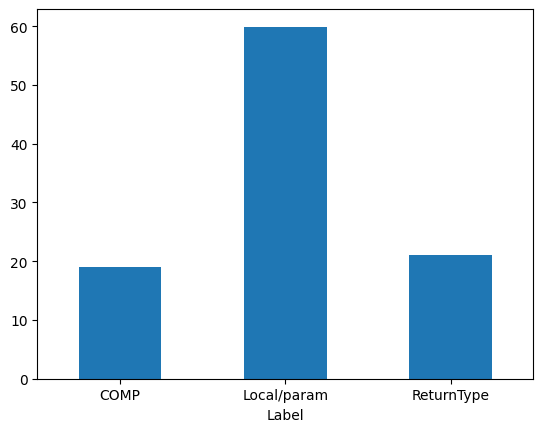

In [19]:
(df.groupby('Label').count().BinaryId/len(df)*100).plot(kind='bar', rot=0)


In [20]:
counts = mdf.groupby('TypeSeq_Debug').count().BinaryId
# counts.sort_values()/len(mdf)
# counts.sort_index()

In [21]:
counts = mdf.groupby('TypeSeq_Debug').count()[['BinaryId']]
counts['TypeSeqLen'] = [len(x.split(',')) for x in counts.index]

In [22]:
# counts.sort_values('TSL').BinaryId/len(mdf)*100
order_idx = sorted(counts.index, key=lambda x: f'{len(x.split(","))}{x}')
counts.loc[order_idx]
(counts.pivot(columns='TypeSeqLen', values='BinaryId')/len(mdf)*100).loc[order_idx]

TypeSeqLen,1,2,3,4
TypeSeq_Debug,,,,
ENUM,2.842185,NaN,NaN,NaN
STRUCT,1.295732,NaN,NaN,NaN
UNION,0.042121,NaN,NaN,NaN
char,6.958039,NaN,NaN,NaN
double,0.162468,NaN,NaN,NaN
float,0.202583,NaN,NaN,NaN
int32,16.549663,NaN,NaN,NaN
int64,4.308408,NaN,NaN,NaN
long double,0.092266,NaN,NaN,NaN


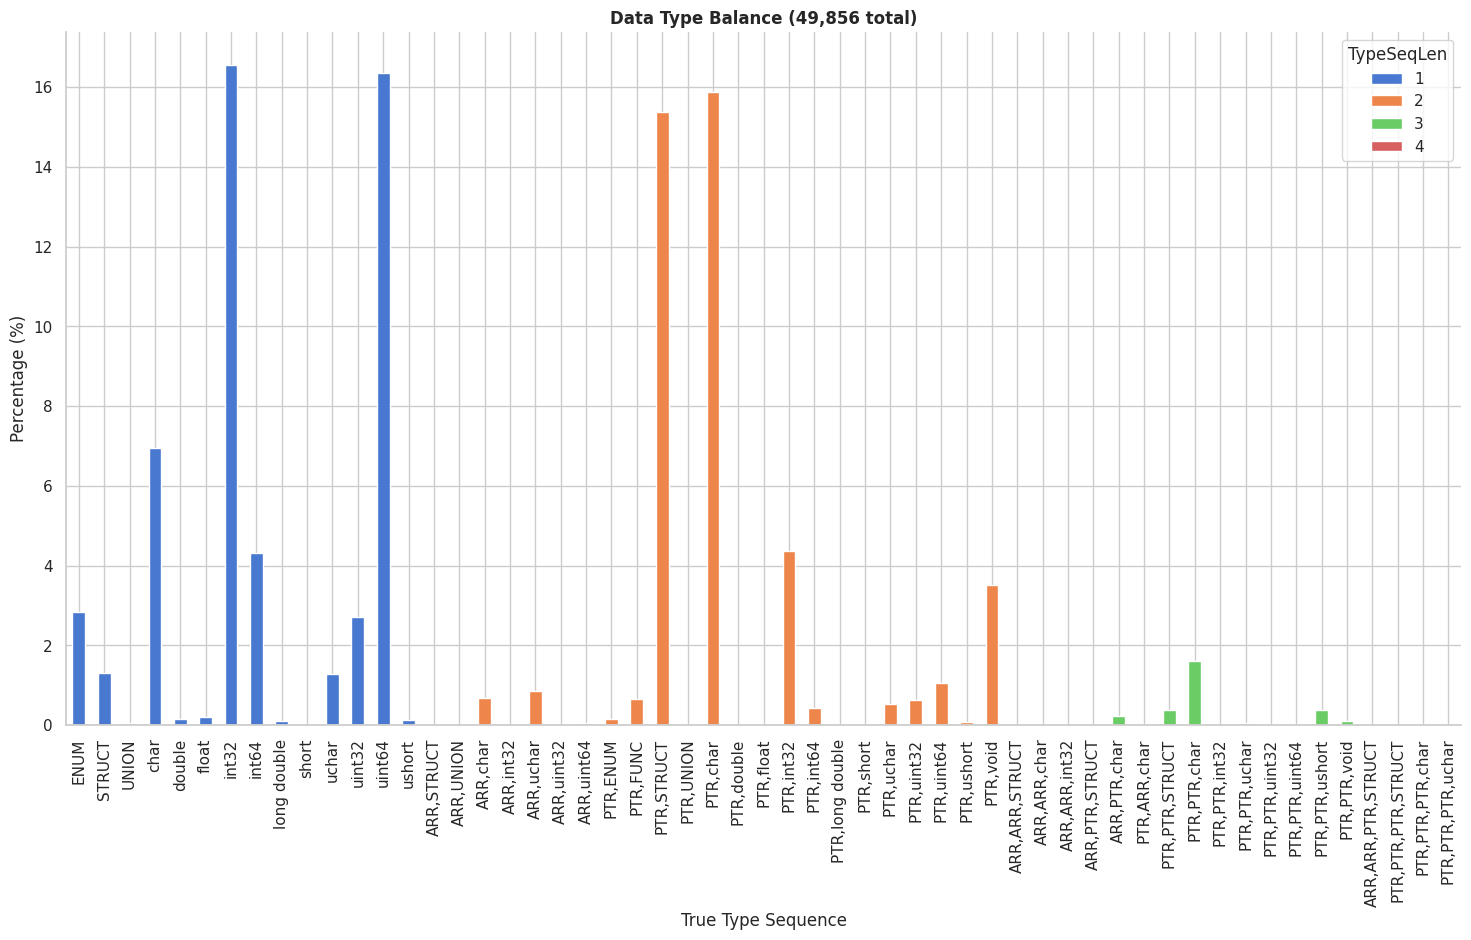

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns

# context: talk, notebook, paper, poster
# palette: muted, Paired, hls, husl, pastel, bright, deep, dark, colorblind
sns.set_theme(style='whitegrid', context='notebook', palette='muted')

order_idx = sorted(counts.index, key=lambda x: f'{len(x.split(","))}{x}')
bal_df = counts.pivot(columns='TypeSeqLen', values='BinaryId').loc[order_idx]/len(mdf)*100

ax = bal_df.plot(kind='bar', stacked=True, figsize=(18, 9))

ax.set_title(f'Data Type Balance ({len(mdf):,} total)', fontweight='bold')#, fontsize=16)
ax.set_xlabel('True Type Sequence')#, fontweight='bold')
ax.set_ylabel('Percentage (%)')
# ax.set_ylim([0, 0.6])
sns.despine()

# Structure Balance

In [131]:
# mdf['HasSTRUCT'] = mdf.TypeSeq_Debug.apply(lambda x: 'STRUCT' in x)
# mdf.groupby('HasSTRUCT').count().BinaryId/len(mdf)*100
sns.set_theme(style='whitegrid', context='talk', palette='muted')# font='Ubuntu')

structs_df = (mdf.groupby(mdf.TypeSeq_Debug.apply(lambda x: 'STRUCT' in x)).count()[['BinaryId']]/len(mdf)*100)
structs_df = structs_df.transpose().reset_index(drop=True).rename({False: 'Other', True: 'STRUCT'},axis=1).rename({0: 'Balance'})
structs_df

TypeSeq_Debug,Other,STRUCT
Balance,82.94087,17.05913


(-0.5, 0.85)

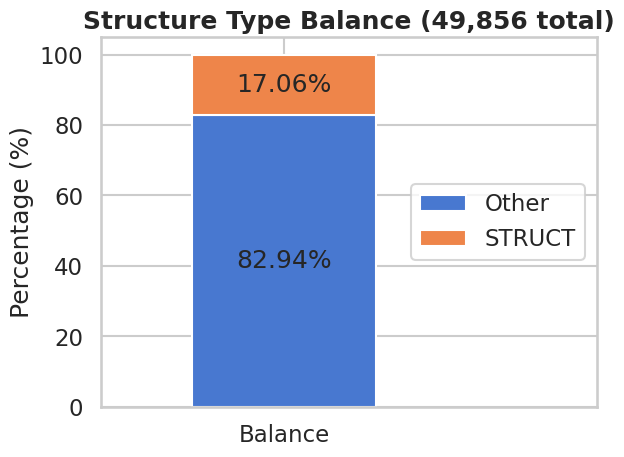

In [132]:
ax = structs_df.plot(kind='bar',
    # figsize=(8,8),
    xlabel='',
    ylabel='Percentage (%)',
    stacked=True,
    rot=0,
)
ax.legend(loc='right')
ax.set_title(f'Structure Type Balance ({len(mdf):,} total)', fontweight='bold')#, fontsize=16)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='center')
ax.set_xlim([-0.5, 0.85])

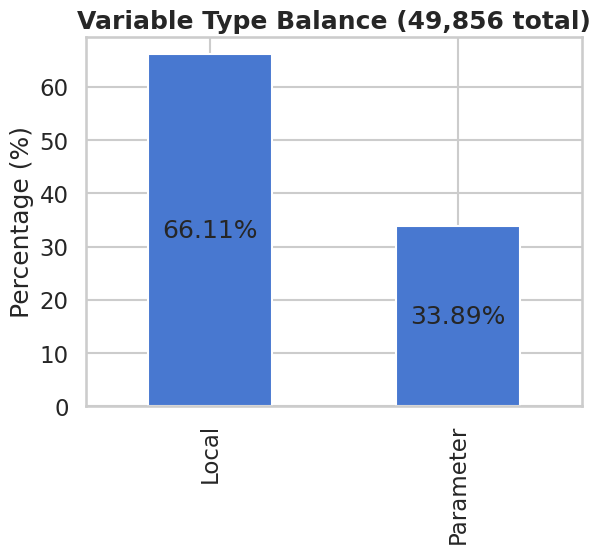

In [25]:
vtype_df = mdf.groupby('Vartype').count()[['BinaryId']]/len(mdf)*100
vtype_df.index = vtype_df.index.map({'l': 'Local', 'p': 'Parameter'})
ax = vtype_df.plot(kind='bar',
    xlabel='',
    ylabel='Percentage (%)',
    legend=False,
)
ax.set_title(f'Variable Type Balance ({len(mdf):,} total)', fontweight='bold')#, fontsize=16)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='center')

In [26]:
import pandas as pd

# pd.read_csv(dataset.root/dataset.raw_file_names[0])
from datatype_recovery.models.dataset import TypeSequenceDataset

ds = TypeSequenceDataset(dataset_path)

In [27]:
exp_runs = pd.read_csv(ds.exp_runs_path)
exp_runs

,RunGid,RunFolder,BinariesCsv,FuncsCsv,ParamsCsv,LocalsCsv
0,0,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...


In [28]:
import pandas as pd
from pathlib import Path
bdf = pd.read_csv(Path.home()/'datasets/coreutils_5hops/raw/binaries.csv')

In [29]:
bdf[bdf.BinaryId==1010]

,BinaryId,Name,RunGid,OrigBinaryId
10,1010,expand,0,10


In [141]:
ldf = pd.read_csv(Path.home()/'exp_builds/coreutils.exp/rundata/run1/locals.csv')
ldf[ldf.FunctionStart==0x10154b]

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,Type_Debug,LocType_Debug,LocRegName_Debug,LocOffset_Debug,TypeCategory_Debug,TypeSeq_Debug,HasDWARF,TypeJson_Debug,BinaryId
5194,1054027,"120,120,120,120",piVar1,int32*,unique,NaN,12544,PTR,"PTR,int32",piVar1,int32*,unique,NaN,12544.0,PTR,"PTR,int32",False,"{""kind"": ""Pointe...",19
5195,1054027,"7,7",bVar2,uchar,unique,NaN,46592,BUILTIN,uchar,bVar2,uchar,unique,NaN,46592.0,BUILTIN,uchar,False,"{""kind"": ""Builti...",19
5196,1054027,"41,41,138,138,21...",uVar3,uint32,unique,NaN,48128,BUILTIN,uint32,uVar3,uint32,unique,NaN,48128.0,BUILTIN,uint32,False,"{""kind"": ""Builti...",19
5197,1054027,"0,0,3,7,41,42,48...",uVar4,ushort,unique,NaN,268435456,BUILTIN,ushort,uVar4,ushort,unique,NaN,268435456.0,BUILTIN,ushort,False,"{""kind"": ""Builti...",19
5198,1054027,"960,960,984",cVar5,char,unique,NaN,268436642,BUILTIN,char,cVar5,char,unique,NaN,268436642.0,BUILTIN,char,False,"{""kind"": ""Builti...",19
5199,1054027,"3,3,4,4,198,198,...",bVar6,uchar,register,al,0,BUILTIN,uchar,bVar6,uchar,register,al,0.0,BUILTIN,uchar,False,"{""kind"": ""Builti...",19
5200,1054027,"962,967,967,971,...",cVar7,char,register,al,0,BUILTIN,char,cVar7,char,register,al,0.0,BUILTIN,char,False,"{""kind"": ""Builti...",19
5201,1054027,"760,760,762,764,...",cVar8,char,register,al,0,BUILTIN,char,cVar8,char,register,al,0.0,BUILTIN,char,False,"{""kind"": ""Builti...",19
5202,1054027,"236,236,241,275,275",uVar9,uint32,register,eax,0,BUILTIN,uint32,uVar9,uint32,register,eax,0.0,BUILTIN,uint32,False,"{""kind"": ""Builti...",19
5203,1054027,"808,808,821,821,...",iVar10,int32,register,eax,0,BUILTIN,int32,iVar10,int32,register,eax,0.0,BUILTIN,int32,False,"{""kind"": ""Builti...",19


In [150]:
!ls ~/exp_builds/coreutils.exp/rundata/run1/19.printenv/ast_dumps/stripped/ | grep 10154
!echo ""
!ls ~/exp_builds/coreutils.exp/rundata/run1/19.printenv/ast_dumps/stripped/ | grep 10154

# TODO: fix this logic - split on '-' and THEN match name.log

FUN_0010154b.log
Func10154b-FUN_0010154b.json

FUN_0010154b.log
Func10154b-FUN_0010154b.json


In [170]:
!ls ~/exp_builds/coreutils.exp/rundata/run1/19.printenv/

fdf = pd.read_csv(Path.home()/'exp_builds/coreutils.exp/rundata/run1/19.printenv/functions.csv')
fdf[fdf.FunctionName_DWARF.isna()]
len(fdf.loc[fdf.FunctionName_DWARF.isna(),:])
len(fdf)
fdf.loc[fdf.FunctionName_DWARF.isna(),:]

19.printenv	       function_params.stats.csv  printenv
19.printenv.debug      functions.csv		  printenv.debug
19.printenv.debug.sdb  ghidra_ast.debug.json	  printenv.dwarf.sdb
19.printenv.sdb        ghidra_ast.json		  _raw_debug_locals.csv
ast_dumps	       locals.csv		  _raw_dwarf_locals.csv
function_params.csv    locals.stats.csv		  _raw_stripped_locals.csv


,FunctionStart,FunctionName_Debug,AstJson_Debug,FunctionName_Strip,AstJson_Strip,FunctionName_DWARF,BinaryId
